_BloomTech Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders` and `pdpbox`.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders
    !pip install pdpbox

# Sprint Challenge: Predict Chicago Food Inspections 🍕

In this challenge, you'll use data from the [Chicago Department of Public Health](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html) to build a model to predict whether a food establishment passed inspection or not.

The purpose of this model is to help inspectors use their time more efficiently by identifying establishments that will likely fail inspection. In other words, this model should be able to predict whether an establishment will fail inspection *before* the inspector arrives at the establishment. 

# Directions

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Identifying data leakage.
- **Task 3:** Writing a wrangle function.
- **Task 4:** Splitting data into a feature matrix and target vector.
- **Task 5:** Splitting data into training and validation sets.
- **Task 6:** Establishing baseline accuracy.
- **Task 7:** Building model with bagging predictor.
- **Task 8:** Building model with boosting predictor.
- **Task 9 (`stretch goal`):** Plotting ROC curves.
- **Task 10:** Generating classification report.
- **Task 11:** Calculating permutation importances.
- **Task 12 (`stretch goal`):** Creating PDP interaction plot.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `pdpbox`
- `sklearn`
- `xgboost`

**A word of warning:** The virtual machine that will check your answers is small. So, where applicable, don't use huge values for `n_estimators` (`>100`) or `n_jobs` (keep at `-1`). 

If you'd like to import all your libraries at the start of your notebook, you can do so in the code block below 👇

In [2]:
# YOUR CODE HERE
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve,roc_auc_score

from sklearn.model_selection import train_test_split

# encoders
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score, mean_absolute_error, r2_score

#pipeline
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Boosted Models
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier 

# Permutation Importance
from sklearn.inspection import permutation_importance 

# for displaying images and html
from IPython.display import Image
from IPython.core.display import HTML 

from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set as the index.

In [3]:
'''T1. Import data file.'''
url = 'https://drive.google.com/uc?export=download&id=1aUnQ4AJK4UtW8JL9zPyYUMtkjIgQpqKT'
df = pd.read_csv(url, parse_dates = ['Inspection Date'], index_col = 'Inspection Date').sort_index()
# YOUR CODE HERE
df

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Type,Violations,Latitude,Longitude,Location,Fail,Serious Violations Found
Inspection Date,,,,,,,,,,,,,,,,,
2010-01-04,70269,mr.daniel's,mr.daniel's,1899292.0,Restaurant,Risk 1 (High),5645 W BELMONT AVE,CHICAGO,IL,60634.0,License Re-Inspection,NaN,41.938443,-87.768318,"{'longitude': '-87.76831838068422', 'latitude'...",0,NaN
2010-01-04,67732,WOLCOTT'S,TROQUET,1992039.0,Restaurant,Risk 1 (High),1834 W MONTROSE AVE,CHICAGO,IL,60613.0,License Re-Inspection,NaN,41.961606,-87.675967,"{'longitude': '-87.67596676683779', 'latitude'...",0,NaN
2010-01-05,96246,THE LEARNING TREE II,THE LEARNING TREE II,1869843.0,Daycare Above and Under 2 Years,Risk 1 (High),8233 S PULASKI RD,CHICAGO,IL,60652.0,License,NaN,41.742993,-87.721558,"{'longitude': '-87.72155821260196', 'latitude'...",0,NaN
2010-01-05,70273,THE GREAT AMERICAN BAGEL,THE GREAT AMERICAN BAGEL (T3-H10),1879164.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666.0,Canvass,"9. WATER SOURCE: SAFE, HOT & COLD UNDER CITY P...",42.008536,-87.914428,"{'longitude': '-87.91442843927047', 'latitude'...",1,0.0
2010-01-05,67758,SU TAQUERIA EL GALLO BRAVO #4,SU TAQUERIA EL GALLO BRAVO #4,1766968.0,Restaurant,Risk 1 (High),5650 W GRAND AVE,CHICAGO,IL,60639.0,Complaint,19. OUTSIDE GARBAGE WASTE GREASE AND STORAGE A...,41.919224,-87.767734,"{'longitude': '-87.76773430251839', 'latitude'...",1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-19,2279606,CITY TAP HOUSE,CITY TAP HOUSE,2646965.0,Restaurant,Risk 1 (High),850 W FULTON MARKET,CHICAGO,IL,60607.0,License,NaN,41.886881,-87.649523,"{'longitude': '-87.64952306435802', 'latitude'...",0,NaN
2019-03-19,2279631,SHOP & SAVE MARKET #2100,SHOP & SAVE MARKET #2100,2327448.0,Grocery Store,Risk 1 (High),6312 N NAGLE AVE,CHICAGO,IL,60646.0,Complaint,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.995985,-87.787637,"{'longitude': '-87.78763711707086', 'latitude'...",1,0.0
2019-03-20,2279709,ST. JOHN FISHER,ST. JOHN FISHER,3076641.0,School,Risk 1 (High),10200 S WASHTENAW AVE,CHICAGO,IL,60655.0,Canvass Re-Inspection,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.708040,-87.689222,"{'longitude': '-87.68922181143849', 'latitude'...",1,0.0


In [4]:
df.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Type',
       'Violations', 'Latitude', 'Longitude', 'Location', 'Fail',
       'Serious Violations Found'],
      dtype='object')

In [5]:
df.shape

(51916, 17)

In [6]:
df.isnull().sum()

Inspection ID                  0
DBA Name                       0
AKA Name                     623
License #                      5
Facility Type                224
Risk                          12
Address                        0
City                          53
State                         10
Zip                           26
Inspection Type                1
Violations                  9655
Latitude                     198
Longitude                    198
Location                     198
Fail                           0
Serious Violations Found    9655
dtype: int64

In [7]:
df['City'].value_counts()

CHICAGO              51659
Chicago                 91
chicago                 34
CCHICAGO                16
SCHAUMBURG               6
CHicago                  5
MAYWOOD                  4
ELK GROVE VILLAGE        4
CICERO                   3
CHESTNUT STREET          3
NILES NILES              2
ELMHURST                 2
SKOKIE                   2
ROSEMONT                 2
EAST HAZEL CREST         2
CHICAGOCHICAGO           2
OAK PARK                 2
ALSIP                    2
NAPERVILLE               2
CHARLES A HAYES          1
HIGHLAND PARK            1
EVANSTON                 1
CHICAGOHICAGO            1
LAKE BLUFF               1
SCHILLER PARK            1
BRIDGEVIEW               1
BEDFORD PARK             1
CHICAGOI                 1
WORTH                    1
CHCHICAGO                1
OOLYMPIA FIELDS          1
CHICAGO HEIGHTS          1
TINLEY PARK              1
SUMMIT                   1
BROADVIEW                1
BERWYN                   1
OLYMPIA FIELDS           1
S

In [8]:
df['State'].value_counts()

IL    51906
Name: State, dtype: int64

In [9]:
df.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Type',
       'Violations', 'Latitude', 'Longitude', 'Location', 'Fail',
       'Serious Violations Found'],
      dtype='object')

In [10]:
df['Facility Type'].value_counts()

Restaurant               34264
Grocery Store             6904
School                    3876
Bakery                     846
Daycare (2 - 6 Years)      830
                         ...  
TEMPORARY KIOSK              1
coffee                       1
Illegal Vendor               1
CONVNIENCE STORE             1
EVENT VENU                   1
Name: Facility Type, Length: 329, dtype: int64

In [11]:
df['Facility Type'].nunique()

329

In [12]:
df['Risk'].value_counts()

Risk 1 (High)      37731
Risk 2 (Medium)    10136
Risk 3 (Low)        4037
Name: Risk, dtype: int64

In [13]:
df['Inspection Type'].value_counts()

Canvass                                   24170
License                                    7825
Canvass Re-Inspection                      6346
Complaint                                  4948
License Re-Inspection                      3002
Complaint Re-Inspection                    2241
Short Form Complaint                       2103
License-Task Force                          214
Suspected Food Poisoning                    207
Consultation                                189
Tag Removal                                 146
Out of Business                             109
Task Force Liquor 1475                       92
Recent Inspection                            66
Suspected Food Poisoning Re-inspection       58
Complaint-Fire                               51
Short Form Fire-Complaint                    36
No Entry                                     21
Special Events (Festivals)                   21
Package Liquor 1474                          16
Complaint-Fire Re-inspection            

In [14]:
df['Violations'].value_counts()

45. FOOD HANDLER REQUIREMENTS MET - Comments: FOUND FOODHANDLERS AT PREMISES WITH NO FOODHANDLER CERTIFICATES. MUST PROVIDE.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [15]:
df['Serious Violations Found'].value_counts()

0.0    34508
1.0     4786
2.0     2148
3.0      627
4.0      155
5.0       19
6.0        9
8.0        5
7.0        4
Name: Serious Violations Found, dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51916 entries, 2010-01-04 to 2019-03-20
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Inspection ID             51916 non-null  int64  
 1   DBA Name                  51916 non-null  object 
 2   AKA Name                  51293 non-null  object 
 3   License #                 51911 non-null  float64
 4   Facility Type             51692 non-null  object 
 5   Risk                      51904 non-null  object 
 6   Address                   51916 non-null  object 
 7   City                      51863 non-null  object 
 8   State                     51906 non-null  object 
 9   Zip                       51890 non-null  float64
 10  Inspection Type           51915 non-null  object 
 11  Violations                42261 non-null  object 
 12  Latitude                  51718 non-null  float64
 13  Longitude                 51718 non-null  fl

**Task 1 Test**

In [17]:
'''T1 Test'''
assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 51916

**Task 2:** Given that this model is supposed to generate predictions *before* an inspection is conducted, identify the numerical feature that is an example of **data leakage.** Assign the column name to the variable `'leaky_col'`.

**Remember:** Leakage is when your feature matrix includes columns that will not be available to your model at the time it make predictions.



In [19]:
'''T2. Identify data leakage column.'''

# YOUR CODE HERE
leaky_col = 'Serious Violations Found'

**Task 2 Test**

In [20]:
'''T2 Test'''
# This is a hidden test. 
# You'll see the result when you submit to Canvas.
assert isinstance(leaky_col, str), '`leaky_col` should be type `str`.'

**Task 3:** Add to the `wrangle` function below so that it does the following:

- Removes the "leaky" column.
- Removes high-cardinality categorical columns (more than `500` categories).
- Removes categorical columns that have only one category.
- Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.

In [21]:
'''T3. Write wrangle function.'''
def wrangle(df):
  df.drop(columns = leaky_col, inplace = True)

  # Drop HCCCs
  cutoff = 500
  drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  df.drop(columns = "State", inplace = True)
  df.drop(columns = ['Inspection ID', 'License #'], inplace = True)

  return df
# YOUR CODE HERE

df = wrangle(df)
df

,Facility Type,Risk,City,Zip,Inspection Type,Latitude,Longitude,Fail
Inspection Date,,,,,,,,
2010-01-04,Restaurant,Risk 1 (High),CHICAGO,60634.0,License Re-Inspection,41.938443,-87.768318,0
2010-01-04,Restaurant,Risk 1 (High),CHICAGO,60613.0,License Re-Inspection,41.961606,-87.675967,0
2010-01-05,Daycare Above and Under 2 Years,Risk 1 (High),CHICAGO,60652.0,License,41.742993,-87.721558,0
2010-01-05,Restaurant,Risk 1 (High),CHICAGO,60666.0,Canvass,42.008536,-87.914428,1
2010-01-05,Restaurant,Risk 1 (High),CHICAGO,60639.0,Complaint,41.919224,-87.767734,1
...,...,...,...,...,...,...,...,...
2019-03-19,Restaurant,Risk 1 (High),CHICAGO,60607.0,License,41.886881,-87.649523,0
2019-03-19,Grocery Store,Risk 1 (High),CHICAGO,60646.0,Complaint,41.995985,-87.787637,1
2019-03-20,School,Risk 1 (High),CHICAGO,60655.0,Canvass Re-Inspection,41.708040,-87.689222,1


**Task 3 Test**

In [22]:
'''T3 Test'''
assert df.select_dtypes('object').nunique().max() < 500, 'Have you dropped the high-cardinality columns?'
assert df.select_dtypes('object').nunique().min() > 1, 'Have you dropped the column with only one category?'

# II. Split Data

**Task 4:** Split the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'Fail'`.

In [30]:
'''T4. Split feature matrix and target vector.'''
target = 'Fail'
# YOUR CODE HERE
y = df[target]
X = df.drop(columns = target)

In [31]:
y.shape, X.shape

((51916,), (51916, 7))

**Task 4 Test**

In [32]:
'''T4 Test'''
assert y.shape == (51916,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 51916, '`X` has the wrong number of rows.'

**Task 5:** Split your dataset into training and validation sets.

- Your training set (`X_train`, `y_train`) should contain inspections conducted before 2017.
- Your validation set (`X_val`, `y_val`) should contain inspections conducted during or after 2017.

In [33]:
'''T5. Split dataset into training and validation sets.'''
# YOUR CODE HERE
cutoff1 = '2017-01-01'
mask = X.index < cutoff1
X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]

In [34]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((41827, 7), (41827,), (10089, 7), (10089,))

In [35]:
y_train

Inspection Date
2010-01-04    0
2010-01-04    0
2010-01-05    0
2010-01-05    1
2010-01-05    1
             ..
2016-12-30    0
2016-12-30    0
2016-12-30    0
2016-12-30    0
2016-12-30    0
Name: Fail, Length: 41827, dtype: int64

**Task 5 Testing**

In [36]:
'''T5 Test'''
assert len(X_train) == len(y_train) == 41827, 'Your training set has the wrong number of observations.'
assert len(X_val) == len(y_val) == 10089, 'Your validation set has the wrong number of observations.'

# III. Establish Baseline

**Task 6:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [37]:
'''T6. Establish baseline accuracy.'''
# YOUR CODE HERE
baseline_acc = y_train.value_counts(normalize = True).max()
print('Baseline accuracy:', baseline_acc)

Baseline accuracy: 0.7506634470557295


**Task 6 Testing**

In [38]:
'''T6 Test'''
assert isinstance(baseline_acc, float), '`baseline_acc` should be type float. Have you defined the variable?'
assert 0.0 <= baseline_acc <= 1.0

# IV. Build Model

In this section, you want to answer the question: Which ensemble method performs better with this data — bagging or boosting?

**Task 7:** Build a model that includes a bagging predictor (`RandomForest`). Your predictor should be part of a pipeline named `model_bag` that includes any transformers that you think are necessary.

In [39]:
'''T7. Build model with bagging predictor.'''
# YOUR CODE HERE
model_bag = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy = 'mean'),
    RandomForestClassifier(n_jobs = -1, n_estimators = 100, max_depth = 6, min_samples_leaf= 8, min_samples_split=8)
)


model_bag.fit(X_train, y_train);
print('Bagging Model')
print('Training accuracy:', model_bag.score(X_train, y_train))
print('Validation accuracy:', model_bag.score(X_val, y_val))

Bagging Model
Training accuracy: 0.7506634470557295
Validation accuracy: 0.7029438001784122


**Tast 7 Testing**

In [43]:
'''T7 Testing'''
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
assert isinstance(model_bag, Pipeline), '`model_bag` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert isinstance(model_bag[-1], RandomForestClassifier), 'Your predictor should be a `RandomForestClassifier`.'
assert hasattr(model_bag[-1], 'feature_importances_'), 'Have you trained your model?'

**Task 8:** Build a model that includes a boosting predictor (`GradientBoostingClassifier` from `sklearn` or `XGBClassifier` from `xgboost`). Your predictor should be part of a pipeline named `model_boost` that includes any transformers that you think are necessary. 

In [44]:
'''T8. Build model with boosting predictor.'''
# YOUR CODE HERE
model_boost = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy = 'mean'),
    XGBClassifier(n_jobs = -1, n_estimators = 100, max_depth = 10, learning_rate=0.05, min_samples_split = 5)
)

model_boost.fit(X_train, y_train);
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))

Training accuracy: 0.789705214335238
Validation accuracy: 0.703934978689662


**Task 8 Testing**

In [45]:
'''T8 Testing'''
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
assert isinstance(model_boost, Pipeline), '`model_boost` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert any([isinstance(model_boost[-1], XGBClassifier),
            isinstance(model_boost[-1], GradientBoostingClassifier)]), 'Your predictor should be `XGBClassifier` or `GradientBoostingClassifier`.'

# V. Check Metrics

Here are the accuracy scores for your two models.

In [46]:
print('Bagging Model')
print('Training accuracy:', model_bag.score(X_train, y_train))
print('Validation accuracy:', model_bag.score(X_val, y_val))
print()
print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))

Bagging Model
Training accuracy: 0.7506634470557295
Validation accuracy: 0.7029438001784122

Boosting Model
Training accuracy: 0.789705214335238
Validation accuracy: 0.703934978689662


**Task 9 (`stretch_goal`):** Plot the ROC-curve for both of your models (you can plot them one-at-a-time, side-by-side, or in the same plot).

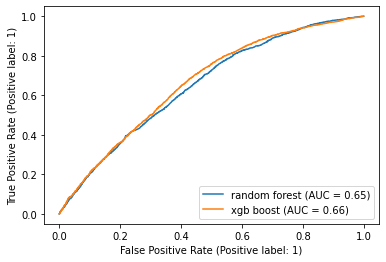

In [47]:
'''T9. Plot ROC-curve.'''
lr = plot_roc_curve(model_bag,
               X_val,
               y_val,
               name='random forest');

rf = plot_roc_curve(model_boost,
               X_val,
               y_val,
               ax=lr.ax_,
               name='xgb boost');


**Task 10:** Choose one of your models based on your validation accuracy score or your ROC curves. Then create a classification report for that model using your validation data. Save the text of the report to the variable name `model_cr`. 

In [48]:
'''T10. Generate classification report for one model.'''
from sklearn.metrics import classification_report

model_cr = classification_report(y_val, model_boost.predict(X_val))
print(model_cr)

              precision    recall  f1-score   support

           0       0.71      0.97      0.82      7092
           1       0.51      0.09      0.15      2997

    accuracy                           0.70     10089
   macro avg       0.61      0.53      0.48     10089
weighted avg       0.65      0.70      0.62     10089



**Task 10 Testing**

In [49]:
assert isinstance(model_cr, str), '`model_cr` should be type `str`.'
assert all(term in model_cr for term in ['precision', 'recall', 'f1-score', 'support']), 'Is this a classification report?'

**Task 11:** Using your best model, create a DataFrame `permutation_importances` with the model's permutation importances based on your validation data.

- The index of the DataFrame should be your feature names.
- The first column should be the mean importance.
- The second column should be the importance standard deviation.

In [50]:
'''T11. Create DataFrame of permutation importances.'''
# YOUR CODE HERE
model_perm = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(n_jobs = -1, n_estimators = 100, max_depth = 10, learning_rate=0.05, min_samples_split = 5) 
)

model_perm.fit(X_train, y_train)

#col = 'quantity'

#X_val_perm = X_val.copy()
#X_val_perm[col] = np.random.permutation(X_val_perm[col])

perm_imp = permutation_importance(model_perm, X_val, y_val,random_state=42)

data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}


permutation_importances = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean')

In [51]:
permutation_importances

,imp_mean,imp_std
City,-0.000317,0.000074
Risk,-0.000020,0.000408
Zip,0.000634,0.001377
Facility Type,0.004559,0.001497
Latitude,0.005848,0.000997
Longitude,0.005848,0.001238
Inspection Type,0.014491,0.001708


**Task 11 Testing**

In [52]:
'''Task 11 Test'''
assert isinstance(permutation_importances, pd.DataFrame), '`permutation_importances` should be type `DataFrame`.'
assert permutation_importances.shape == (7,2)

**Task 12 (`stretch goal`):** Using your best model, create a PDP interaction plot to examine how `'Latitude'` and `'Longitude'` inform predictions. Remember to user your validation data.

**Note:** Because of the way that `pdp_interact` works, it will throw an error if there are `NaN` values in your validation set. To avoid this problem, be sure to set `dataset` to `X_val.dropna()`.

In [53]:
df.columns

Index(['Facility Type', 'Risk', 'City', 'Zip', 'Inspection Type', 'Latitude',
       'Longitude', 'Fail'],
      dtype='object')

In [54]:
feature = 'Longitude'

In [55]:
isolate= pdp_isolate(
    model_boost,
    dataset= X_val.dropna(), # USE YOUR VALIDATION DATA
    model_features=X_val.columns,
    feature = feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f76d0521f90>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f76d0227090>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


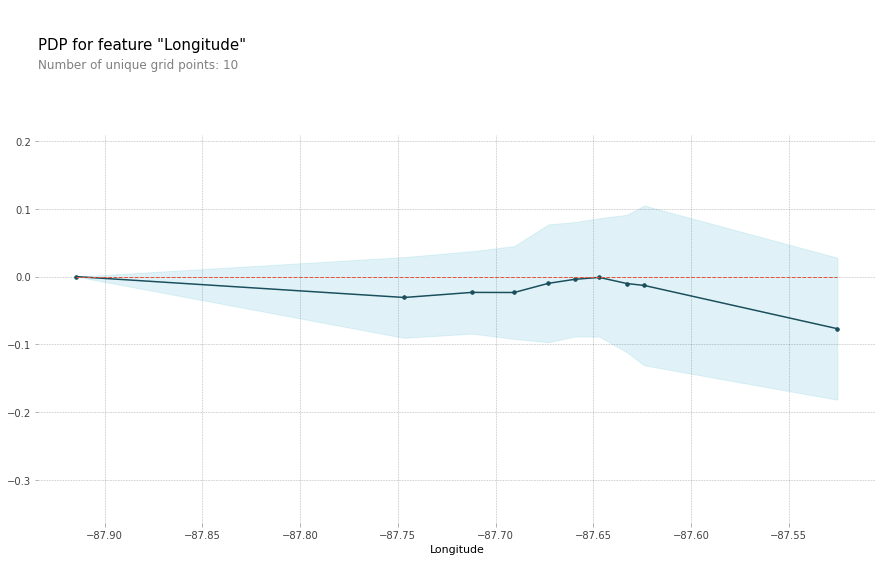

In [56]:
pdp_plot(isolate, feature_name=feature)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f76d0cb2950>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f76d02275d0>})

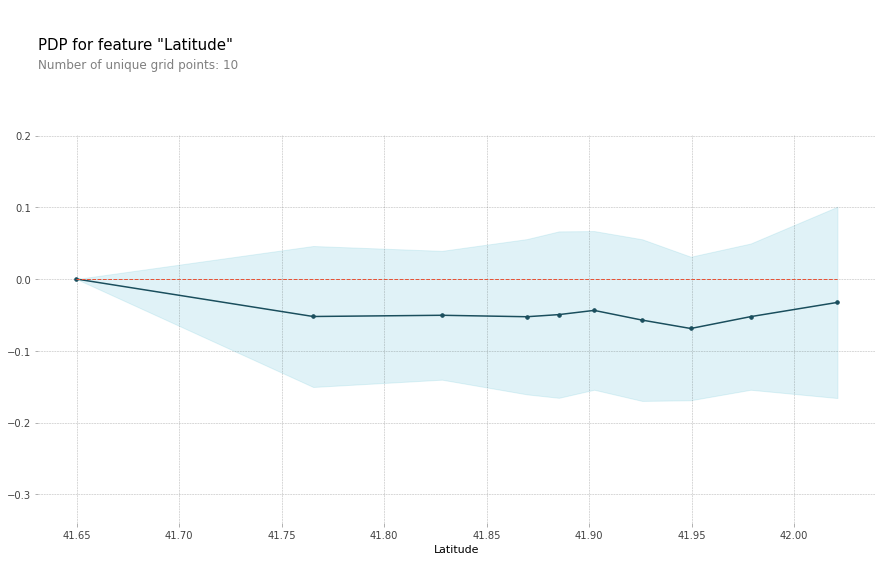

In [57]:
feature = 'Latitude'
isolate= pdp_isolate(
    model_boost,
    dataset= X_val.dropna(), # USE YOUR VALIDATION DATA
    model_features=X_val.columns,
    feature = feature
)
pdp_plot(isolate, feature_name=feature)

In [58]:
'''T12. Create PDP interaction plot for "Latitude" and "Longitude".'''
features = ['Longitude', 'Latitude']
# YOUR CODE HERE
interact= pdp_interact(
    model_boost,
    dataset= X_val.dropna(), 
    model_features=X_val.columns,
    features = features
)

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f76d0b1c7d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f76d0ba1c10>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


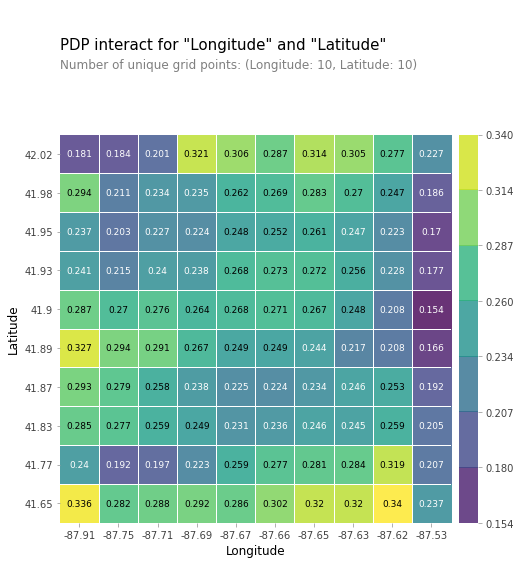

In [59]:
pdp_interact_plot(interact,plot_type='grid', feature_names=features)